In [87]:
import numpy as np
import pandas as pd

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder


# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

trn = pd.read_csv('Data/train.csv')
tst = pd.read_csv('Data/test.csv')
n_trn = len(trn)
df = pd.concat([trn, tst])
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


# Modify features

PassengerId and Ticket are highly unlikely to be relevant, so delete them. Also delete Cabin because most values are mising. Additionally, recode Sex as 'm'/'f'.

In [3]:
df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
df.Sex.replace(['male', 'female'], ['m', 'f'], inplace=True)
df.Survived.replace([1, 0], [True, False], inplace=True)
df.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,m,1,0.0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,f,1,1.0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,f,0,1.0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,f,1,1.0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,m,0,0.0


## Imputation

First, see how many values are missing in each column.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Age         1046 non-null float64
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
dtypes: float64(3), int64(3), object(3)
memory usage: 102.3+ KB


Embarked and Fare are missing very few values. Simply fill these with the appropriate mode and relevant median, respectively, after inspection.

In [5]:
# Display table with counts for each value of Embarked
print(df['Embarked'].value_counts())
# Value 'S' is by far the most common, so set the missing values to S.
df['Embarked'].fillna('S', inplace=True)


S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [6]:
# Get row of passenger with fare information missing
df[df['Fare'].isnull()]

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived
152,60.5,S,NaN,"Storey, Mr. Thomas",0,3,m,0,NaN


In [7]:
# Get median fare paid by passengers in the same class, from the same destination and place it.
median_fare = df[np.logical_and(df['Pclass']==3, df['Embarked']=='S')]['Fare'].median()
median_fare = df[np.logical_and(df['Pclass']==3, df['Embarked']=='S')]['Fare'].median()
df['Fare'].fillna('S', inplace=True)
# Check only Survived (naturally only has values for training set) and Age (to be done later, if at all) have missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Age         1046 non-null float64
Embarked    1309 non-null object
Fare        1309 non-null object
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 102.3+ KB


In [8]:
# Embarked would likely only be relevant in so far as it is an indicator of socioeconomic class. But since we now have complete
# information for Fare as well as Pclass, we can discard it.
df.drop(['Embarked'], axis=1, inplace=True)

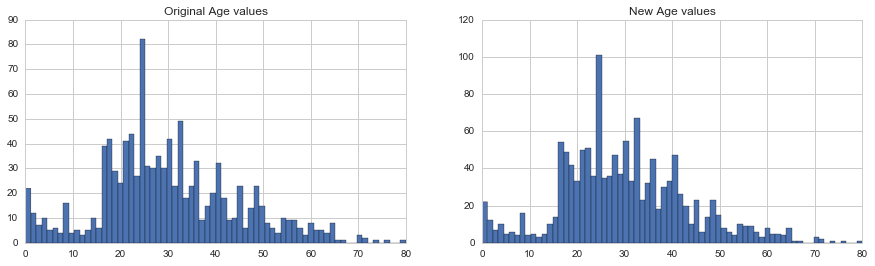

In [9]:
# Fill in missing age values by sampling randomly from the existing values.

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values')
axis2.set_title('New Age values')

# get average, std, and number of NaN values in df
average_age   = df["Age"].mean()
std_age      = df["Age"].std()
count_nan_age = df["Age"].isnull().sum()

# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age - std_age, average_age + std_age, size = count_nan_age)

# plot original Age values
# NOTE: drop all null values, and convert to int
df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
df.loc[np.isnan(df["Age"]), "Age"] = rand_1

# convert from float to int
df['Age'] = df['Age'].astype(int)
        
# plot new Age Values
df['Age'].hist(bins=70, ax=axis2)

In [10]:
# Check all missing values have been taken care of
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
Age         1309 non-null int32
Fare        1309 non-null object
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
dtypes: float64(1), int32(1), int64(3), object(3)
memory usage: 86.9+ KB


# Some exploratory plots
Make some plots to gain intuition about suitable models

Would be better to have sample sizes for each plot in titles.


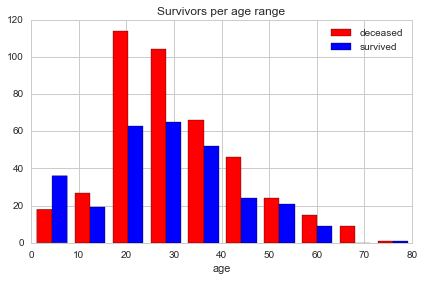

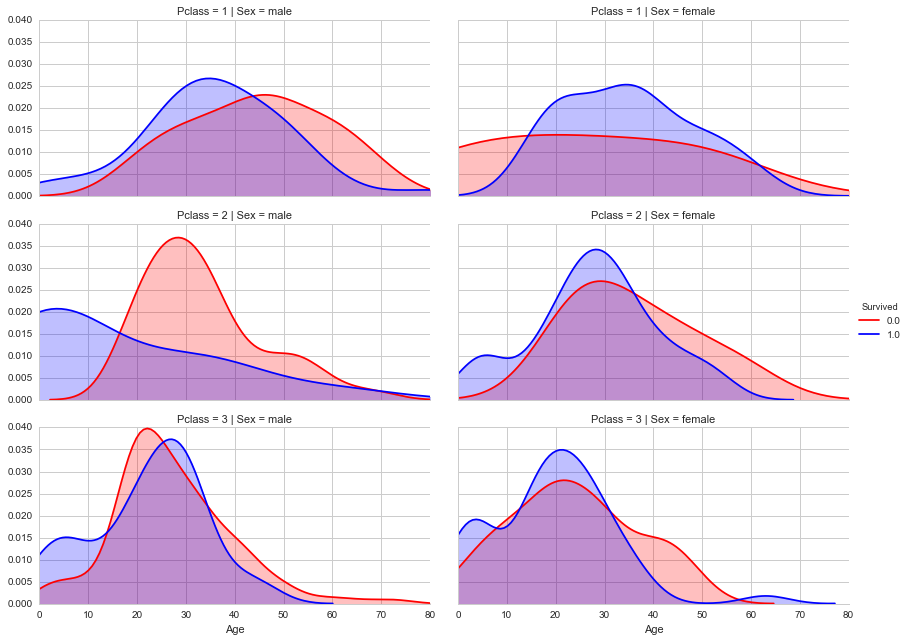

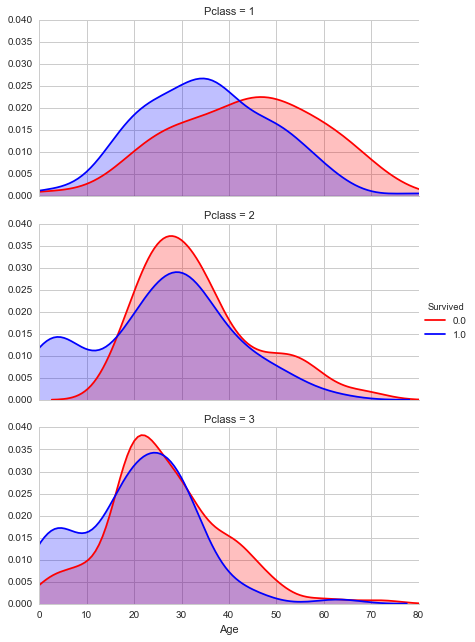

In [78]:
df_trn = df[:n_trn]

n_bins = 10
x1 = np.array(df_trn['Age'][np.logical_and(df_trn['Survived']==0, -np.isnan(df_trn['Age']))])
x2 = np.array(df_trn['Age'][np.logical_and(df_trn['Survived']==1, -np.isnan(df_trn['Age']))])
x=[x1,x2]

# fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,5))
plt.figure()

colors = ['red', 'blue']
plt.hist(x, n_bins, normed=0, histtype='bar', color=colors, label=['deceased', 'survived'])
plt.legend(prop={'size': 10})
plt.title('Survivors per age range')
plt.xlabel('age')
plt.tight_layout()

# Seaborn Facets
# plt.figure(figsize=(5,3))

# peaks for survived/not survived passengers by their age


facet = sns.FacetGrid(df_trn, row='Pclass', col='Sex', hue="Survived", aspect=2, palette=['red','blue'])
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_trn['Age'].max()))
facet.add_legend()


facet = sns.FacetGrid(df_trn, row='Pclass', hue="Survived", aspect=2, palette=['red','blue'])
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_trn['Age'].max()))
facet.add_legend()


#fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))

#x1m = np.array(df_trn['Age'][np.logical_and(df_trn['Survived']==0, -np.isnan(df_trn['Age']))])
#x2f = np.array(df_trn['Age'][np.logical_and(df_trn['Survived']==1, -np.isnan(df_trn['Age']))])
#x=[x1,x2]

#plt.subplot(121)
#plt.hist(x, n_bins, normed=0, histtype='bar', color=colors, label=['deceased', 'survived'])
#plt.legend(prop={'size': 10})
#plt.title('Survivors per age range')
#plt.xlabel('age')
#plt.tight_layout()


print('Would be better to have sample sizes for each plot in titles.')


# Logistic regression
## Naive
A univariate logstic regression for survival as a function of age should not work well based on the graphs above, at least without a transformation. Try it as a point of reference.

In [43]:
x = df_trn['Age'].reshape(-1,1)
y = df_trn['Survived'].ravel()

logreg1 = LogisticRegression()
logreg1.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
print("Model score: " + str(logreg1.score(x, y)))

Model score: 0.616161616162


A score of 61% seems rather low (but was expected). Have a look at the null error rate:

In [16]:
df_trn['Survived'].mean()

0.3838383838383838

This suggests the model is simply predicting survival for noone. Inspect the coefficients to confirm:

In [32]:
print(" Age coefficient: " + str(logreg1.coef_[0, 0]))
print(" Intercept: " + str(logreg1.intercept_[0]))

 Age coefficient: -0.0125824443032
 Intercept: -0.102128746323


Indeed, this clearly results in negative predictions for all (positive) ages.

## Quadratic in Age
The histogram of survival by age above suggests a quadratic function on age is likely a much better predictor for survival. Cubic would likely be better still, but is not considered here.

In [56]:
# Now do logistic regression again, but with the quadratic age term added
logreg2 = make_pipeline(PolynomialFeatures(2, include_bias = False), LogisticRegression())
logreg2.fit(x,y)

#logreg2.fit(poly_x, y)
print("Model score: " + str(logreg2.score(x, y)))

Model score: 0.624017957351


This is technically an improvement, but a tiny one. Inspect the coefficients:

In [80]:
print(" Age coefficients: " + str(logreg2.steps[1][1].coef_))
print(" Intercept: " + str(logreg2.steps[1][1].intercept_[0]))


 Age coefficients: [[-0.02829229  0.00030254]]
 Intercept: 0.0218849467137


## Linear, in Age, Class, Sex

In [85]:
#x_acs =  df_trn[['Age', 'Pclass', 'Sex']]
x_acs =  df_trn[['Age', 'Sex']]

onehot = OneHotEncoder()
onehot.fit()

logreg3 = LogisticRegression()
logreg3.fit(x_acs, y)

# USE sklearn OneHotEncoder to preprocess categorical variables. Pipeline?

ValueError: could not convert string to float: 'male'